# Project 3: Panoramic Mosaicing

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">~1 Hour, maybe a little more</span>
* 2. Part B: <span style="color:red;">~1.5 Hours, maybe a little more</span>
* 3. Part C: <span style="color:red;">~4 Hours, maybe a little more</span>
* 4. Part D: <span style="color:red;">~8 Hours, maybe a little more. I spent SO LONG trying to improve the image. I tried roughly 4 different methods to try and improve it. Not much luck with most of them.</span>
* 5. Write-up: <span style="color:red;">~30 minutes to get everything how I wanted it.</span>

### Programming Exercise

For this assignment, you will be writing a program that creates a panoramic mosaic from 2 or more images.  In general this technique should be applicable to any number of photographs.  The approach described below will work well for collective fields of up to 90 or even 120&deg;, but won't produce ideal results for large fields of view approaching or surpassing 180&deg;.  For large fields of view cylindrical or spherical projection is required.

When we construct a panorama, we assume that all of the photographs were taken from the exact same location and that the images are related by pure rotation (no translation of the camera).  The easiest way to create the panorama is to project all of the photos onto a plane.  One photo must be selected (either manually or by your program) to be the base photo.  The other photos are aligned to this base photo by identifying a homography (a planar warp specified by 4 pairs of source/destination points) relating each pair.  Each of the other images is appropriately warped and composited onto the plane (the base image doesn’t need to be warped).

In describing what you need to do, there will be a running example using the three photos below:


<div style="width:100%;text-align:center;"><img src="Images/example1.png" width=100%></div>
        

### Part A: Find Interest Points/Descriptors in each Input Image
We will be using OpenCV for this project, which you should already have installed.  However, you may need to install the contrib version--which comes seperate due to the SIFT algorithm being patented--by running the command:`pip install opencv-contrib-python`.  A good tutorial on how to use SIFT features in OpenCV is found [here](https://docs.opencv.org/trunk/da/df5/tutorial_py_sift_intro.html).  The first step to registering or aligning two images is to identify locations in each image that are distinctive or stand out.  The `sift.detectAndCompute()` routine produces both these interest points and their corresponding SIFT descriptors.  The first step of producing a panorama is to load all of the relevant images and find the interest points and their descriptors.

See the red circles on each image below indicating the sift keypoints that were found (note that we downsampled the images to 600 x 600 pixels before extracting SIFT).  We scaled the circles according to the scale at which each keypoint was detected at.

<div style="width:100%;text-align:center;"><img src="Images/example2.png" width=100%></div>

### Part B: Matching Features

Next, given the features present in each image, you need to match the features so as to determine corresponding points between adjacent/overlapping images.  [This page](https://docs.opencv.org/trunk/dc/dc3/tutorial_py_matcher.html) provides details to do feature matching using `cv2.BFMatcher()`, analogous to the approach proposed by David Lowe in his original implementation.  Be aware that the resulting match is one directional.  You want to find putative pairs--pairs of points which are each other’s best match (e.g. there might be 3 points in image I1 for which a point q in image I2 are the best match, only one of these could be the best matching point p in I1 for that point q in I2).  In this part you need to compute the set of putative matches between each pair of images.

Look at the pairs of images and the lines showing the estimated matches (putative matches are green lines, one way matches are cyan or blue).

<div style="width:100%;text-align:center;"><img src="Images/example3.png" width=100%></div>

### Part C: Estimating Pairwise Homographies using RANSAC

Use the RANSAC algorithm ([Szeliski](http://szeliski.org/Book/), Ch 6.1.4), estimate the homography between each pair of images.  You will need to decide whether you’re going to manually specify the base image or determine in programmatically.  Along with identifying the base image, you need to figure out the order in which you will composite the other images to the base.

You will need 4 pairs of points to estimate a homography.  Begin by randomly sampling sets of 4 pairs and estimating the corresponding homography for each set.  Instead of the two warping equations that we used earlier in the semester, it is recommended that you use a 3x3 homography (8 unknowns).  You are trying to estimate the homography

$$
\begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}
$$

such that a point $(x_s,y_s)$ in the source image is tranformed to a point $(x_t,y_t)$ in the target image as follows

$$
\begin{bmatrix}x_t\\y_t\\1\end{bmatrix} = \begin{bmatrix}a & b & c\\d & e & f\\g & h & 1\end{bmatrix}\begin{bmatrix}x_s\\y_s\\1\end{bmatrix}
$$

Each pair of points will produce three linear equations in (a subset of) the 8 unknowns.  For example, $x_t = x_sa + y_sb + c$.  Four pairs of points (assuming no degeneracies) are sufficient to estimate the homography.  A more robust solution relying on more than four pairs can be obtained using least squares on the overconstrained linear system (solving $Ax = b$, where $x$ is a column vector with the 8 unknowns and you populate rows of $A$ and an entry of $b$ with the linear equations just described).  Note that this solution will **not** always be better.

Because of the homogeneous coordinates, the three equations can be reduced to two equations as follows:

$$
x_t = \frac{ax_s+by_s+c}{gx_s+hy_s+1}, \hspace{5mm}
y_t = \frac{dx_s+ey_s+f}{gx_s+hy_s+1}
$$

For more details, see the [image alignment and stitching slides](https://faculty.cs.byu.edu/~farrell/courses/CS450/slides/alignment_stitching.pdf#page=18).

Below you will find a visualization of the RANSAC estimated homographies.  Images 1, 2, and 3 have dots that are red, green and blue respectively (sorry the dots are a little small), representing the putative pairs.  You can see where the homographies line up very well and in a few places (the middle vertically) they line up slightly less well.

<div style="width:100%;text-align:center;"><img src="Images/example4.png" width=100%></div>

### Part D: Creating the Mosaic

Begin with the base image and warp the remaining images (using the estimated homographies) to composite them onto the base image.

For the ongoing campus example, here are the resulting warped images composited.

<div style="width:100%;text-align:center;"><img src="Images/example5.png" width=75%></div>

And, then with a very simple (but not ideal) compositing operation.

<div style="width:100%;text-align:center;"><img src="Images/example6.png" width=75%></div>

In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

### Part A: Find Interest Points/Descriptors

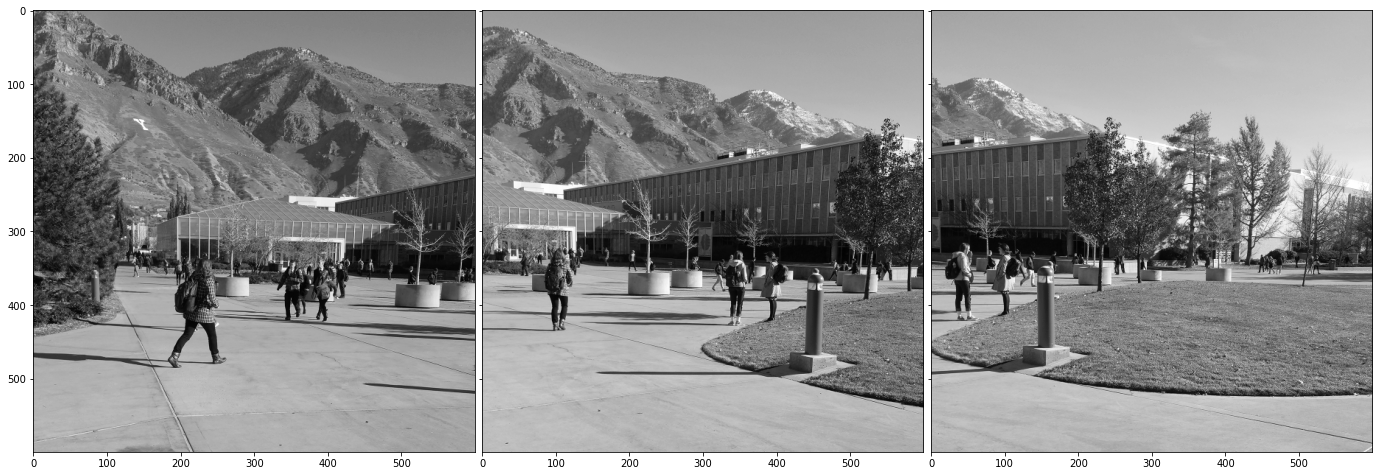

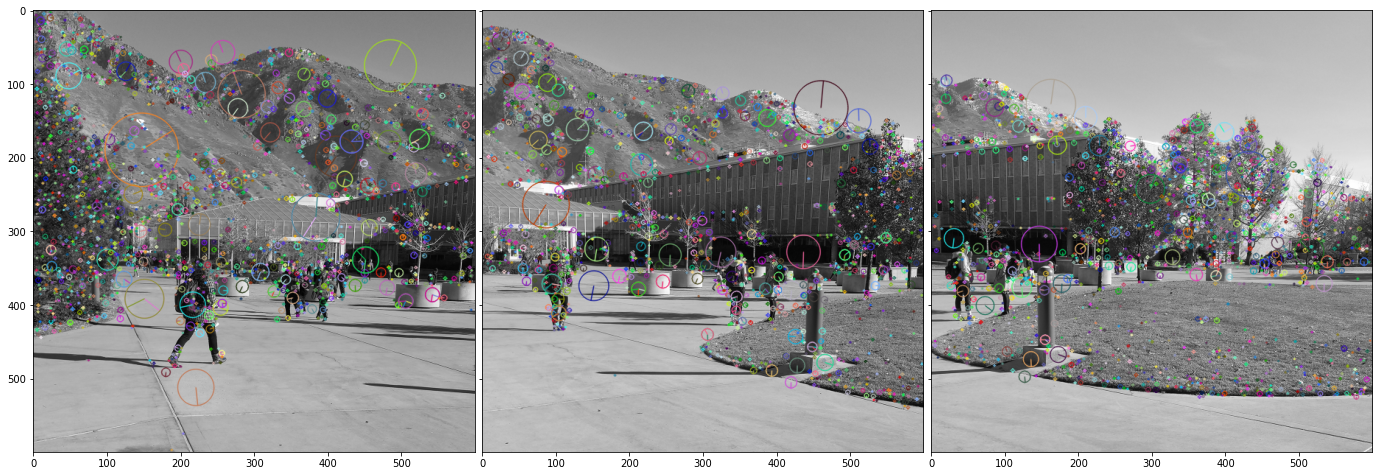

In [2]:
# Place Code Here

# load images
image_left = cv2.imread('./images/width600/campus1_sq600.png')
image_left_gray = cv2.cvtColor(image_left, cv2.COLOR_BGR2GRAY)
image_center = cv2.imread('./images/width600/campus2_sq600.png')
image_center_gray = cv2.cvtColor(image_center, cv2.COLOR_BGR2GRAY)
image_right = cv2.imread('./images/width600/campus3_sq600.png')
image_right_gray = cv2.cvtColor(image_right, cv2.COLOR_BGR2GRAY)
#print(image_left.size)

# Show an example output here
fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [image_left_gray, image_center_gray, image_right_gray]):
    ax.imshow(im, cmap='gray')
    #ax.title = "Original"
plt.show()
#cv2.imshow("left", image_left)

siftL = cv2.SIFT_create()
kp_left, des_left = siftL.detectAndCompute(image_left_gray,None)
sift_left=cv2.drawKeypoints(image_left_gray,kp_left,image_left.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

siftC = cv2.SIFT_create()
kp_center, des_center = siftC.detectAndCompute(image_center_gray, None)
sift_center = cv2.drawKeypoints(image_center_gray,kp_center,image_center.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

siftR = cv2.SIFT_create()
kp_right, des_right = siftR.detectAndCompute(image_right_gray, None)
sift_right = cv2.drawKeypoints(image_right_gray,kp_right,image_right.copy(),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)    

fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [sift_left, sift_center, sift_right]):
    ax.imshow(im, cmap='gray')
    #ax.title = "Original"
plt.show()

### Part B: Matching Features

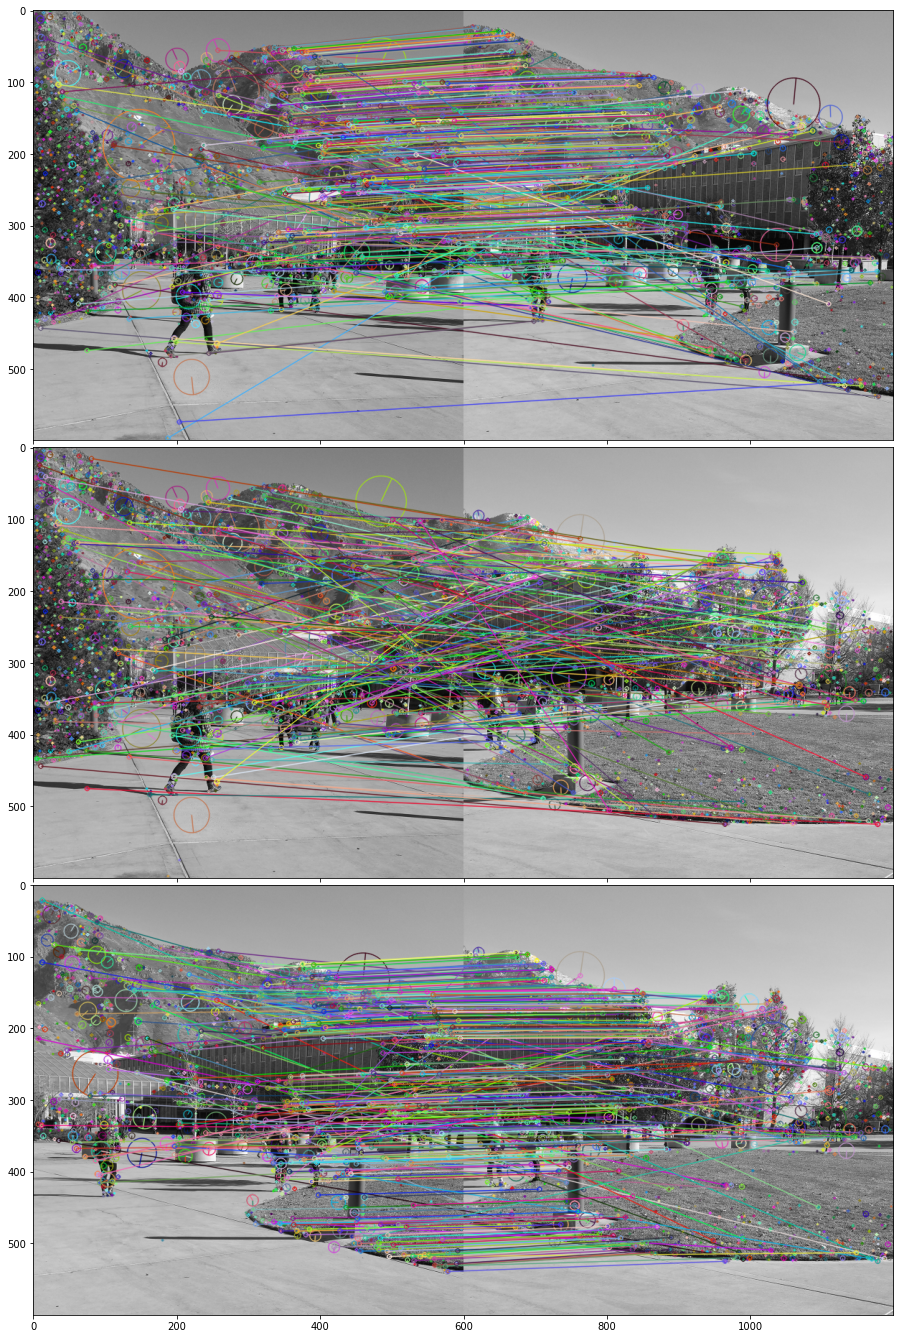

In [3]:
# Place Code Here
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
# what are the descriptors?
matches_lr = bf.match(des_left, des_right)
matches_lc = bf.match(des_left, des_center)
matches_cr = bf.match(des_center, des_right)
#matches = sorted(matches, key = lambda x:x.distance)
# Apply ratio test
good_lr = []
good_lc = []
good_cr = []
CRITERION = 2000
for m in matches_lr:
    if m.distance < CRITERION:
        good_lr.append([m])
for m in matches_lc:
    if m.distance < CRITERION:
        good_lc.append([m])
for m in matches_cr:
    if m.distance < CRITERION:
        good_cr.append([m])

# Draw first 10 matches.
img_lc = cv2.drawMatchesKnn(sift_left.copy(),kp_left,sift_center.copy(),kp_center,good_lc,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_lr = cv2.drawMatchesKnn(sift_left.copy(),kp_left,sift_right.copy(),kp_right,good_lr,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_cr = cv2.drawMatchesKnn(sift_center.copy(),kp_center,sift_right.copy(),kp_right,good_cr,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)


fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [img_lc, img_lr, img_cr]):
    ax.imshow(im, cmap='gray')
plt.show()

# Show an example output here

### Part C: Estimating Pairwise Homographies using RANSAC

In [4]:
def createMatrix(points):
    A = np.zeros((2*len(points), 8))
    idx = 0
    
    for point in points:
        x1 = point[0][0]
        y1 = point[0][1]
        xp1 = point[1][0]
        yp1 = point[1][1]
        A[idx] = x1,y1,1.0,0.0,0.0,0.0,-1*xp1*x1,-1*xp1*y1
        idx += 1
        A[idx] = 0.0,0.0,0.0,x1,y1,1.0,-1*yp1*x1,-1*yp1*y1
        idx += 1
    return A

In [5]:
def createPrime(points):
    prime = []
    for point in points:
        #prime.append([point[0][0]])
        #prime.append([point[0][1]])
        prime.append([point[1][0]])
        prime.append([point[1][1]])
    return prime

In [40]:
def RANSAC(good_input, kp_query, kp_targ):
    # Place Code Here
    best_homography = None
    best_homography3x3 = None
    best_consensus_set = []
    for i in range(3000):
    # test and confirm homography works correctly for 4 random points
        try:
            points = []
            idxs = []
            for i in range(4):
                idx = random.randint(0, len(good_input)-1)
                if idx in idxs:
                    continue
                idxs.append(idx)
                xy = kp_query[good_input[idx][0].queryIdx].pt
                xpyp = kp_targ[good_input[idx][0].trainIdx].pt
                points.append([xy, xpyp])

            A = createMatrix(points)
            prime = createPrime(points)
            homography = np.linalg.lstsq(A, prime)[0]
            #print(homography)

            homography3x3 = np.array([[homography[0][0],homography[1][0],homography[2][0]],[homography[3][0],homography[4][0],homography[5][0]],[homography[6][0],homography[7][0],1]])
            #print(homography3x3)
            consensus_set = []
            THRESHOLD = 2
            for match in range(len(good_input)):
                xy = kp_query[good_input[match][0].queryIdx].pt
                xpyp = kp_targ[good_input[match][0].trainIdx].pt
                #print("orig: ", xpyp)
                temp = np.array([[xy[0]], [xy[1]], [1]])
                newxy = (np.matmul(homography3x3, temp)) # use matmul instead of dot product
                newxpyp = newxy[0][0], newxy[1][0]
                #print("new: ", newxpyp)
                if np.abs(xpyp[0] - newxpyp[0]) < THRESHOLD and np.abs(xpyp[1] - newxpyp[1]) < THRESHOLD:
                    #print("orig: ", xpyp)
                    #print("new: ", newxpyp)
                    consensus_set.append(good_input[match])
            #print(len(consensus_set))
            if len(consensus_set) > len(best_consensus_set):
                best_consensus_set = consensus_set
                best_homography = homography
                best_homography3x3 = homography3x3
        except:
            print("this iteration is no good")
    return best_consensus_set, best_homography, best_homography3x3

In [41]:
def calculate_final_homography(best_consensus_set, kp_query, kp_targ):
    #print(len(best_consensus_set))
    #print(best_consensus_set)
    #np.linalg.lstsq(, )
    points2 = []

    for match in best_consensus_set:
        xy = kp_query[match[0].queryIdx].pt
        #if xy[0] < min_x:
        #    min_x = xy[0]
        #if xy[0] > max_x:
        #    max_x = xy[0]
        #if xy[1] < min_y:
        #    min_y = xy[1]
        #if xy[1] > max_y:
        #    max_y = xy[1]
        xpyp = kp_targ[match[0].trainIdx].pt
        points2.append([xy, xpyp])
    
    H = createMatrix(points2)
    prime2 = np.array(createPrime(points2))
    final_homography = np.append(np.linalg.lstsq(H, prime2)[0], 1).reshape(3, 3)
    #print("min_x: {}, min_y: {}, max_x: {}, max_y: {}".format(min_x, min_y, max_x, max_y))
    return final_homography

In [42]:
def overlay_transparent(background, overlay, x, y):

    background_width = background.shape[1]
    background_height = background.shape[0]

    if x >= background_width or y >= background_height:
        return background

    h, w = overlay.shape[0], overlay.shape[1]

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :3]
    mask = overlay[..., 3:] / 255.0

    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

In [43]:
best_consensus_set_lc, best_homography_lc, best_homography3x3_lc = RANSAC(good_lc, kp_left, kp_center)
final_homography_lc = calculate_final_homography(best_consensus_set_lc, kp_left, kp_center)

best_consensus_set_lr, best_homography_lr, best_homography3x3_lr = RANSAC(good_lr, kp_left, kp_right)
final_homography_lr = calculate_final_homography(best_consensus_set_lr, kp_left, kp_right)

best_consensus_set_cr, best_homography_cr, best_homography3x3_cr = RANSAC(good_cr, kp_center, kp_right)
final_homography_cr = calculate_final_homography(best_consensus_set_cr, kp_center, kp_right)

C:\Users\Trevi\AppData\Local\Temp/ipykernel_11408/2832126969.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  homography = np.linalg.lstsq(A, prime)[0]


In [44]:
def merge_images_temp(dx, dy, basePos, baseImg, transImg, final_homography, or_str):
    canvas = np.zeros((800, 1000, 3))
    canvas[100:700,basePos:basePos+600] += baseImg
    transform = np.matmul([[1,0,dx],[0,1,dy],[0,0,1]], final_homography)
    cv2.imwrite('canvas_{}.jpg'.format(or_str), canvas)
    warped = cv2.warpPerspective(transImg, transform, (600, 800))
    cv2.imwrite('warped_{}.jpg'.format(or_str), warped)
    

In [45]:
def merge_images(dx, dy, transImg, final_homography, inp_x, inp_y):
    transform = np.matmul([[1,0,dx],[0,1,dy],[0,0,1]], final_homography)
    combined = cv2.warpPerspective(transImg, transform, (inp_x, inp_y))
    return combined

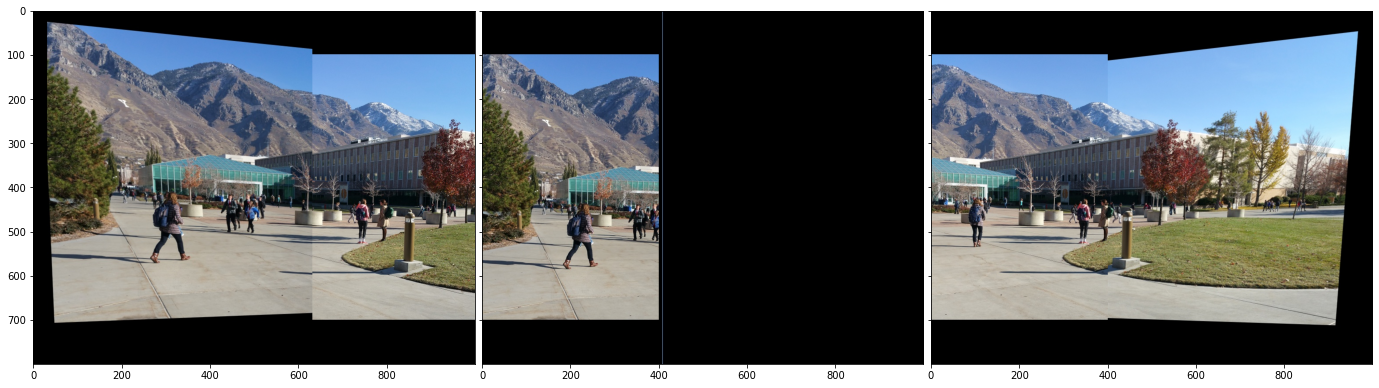

In [46]:
#canvas = np.zeros((800, 1000, 3))
#canvas[100:700,400:] += image_center
#dx = 360
#dy = 94
#transform = np.matmul([[1,0,dx],[0,1,dy],[0,0,1]], final_homography_lc)
#cv2.imwrite('canvas.jpg', canvas)
#warped_left = cv2.warpPerspective(image_left, transform, (600, 800))
#cv2.imwrite('warped_left.jpg', warped_left)
merge_images_temp(360, 94, 400, image_center, image_left, final_homography_lc, "lc")
merge_images_temp(10,40, 0, image_left, image_right, final_homography_lr, "lr")
merge_images_temp(-400, 100, 0, image_center, image_right, np.linalg.inv(final_homography_cr), "cr")

im = cv2.imread('canvas_lc.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('warped_lc.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
final_lc = overlay_transparent(im.copy(), im2, 32, 0)
im = cv2.imread('canvas_lr.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('warped_lr.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
final_lr = overlay_transparent(im.copy(), im2, 400, 0)
im = cv2.imread('canvas_cr.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('warped_cr.jpg')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
final_cr = overlay_transparent(im.copy(), im2, 400, 0)

fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [final_lc, final_lr, final_cr]):
    ax.imshow(im)
plt.show()

### Part D: Creating the Mosaic

1407 970
x's:  375.2
y's:  194


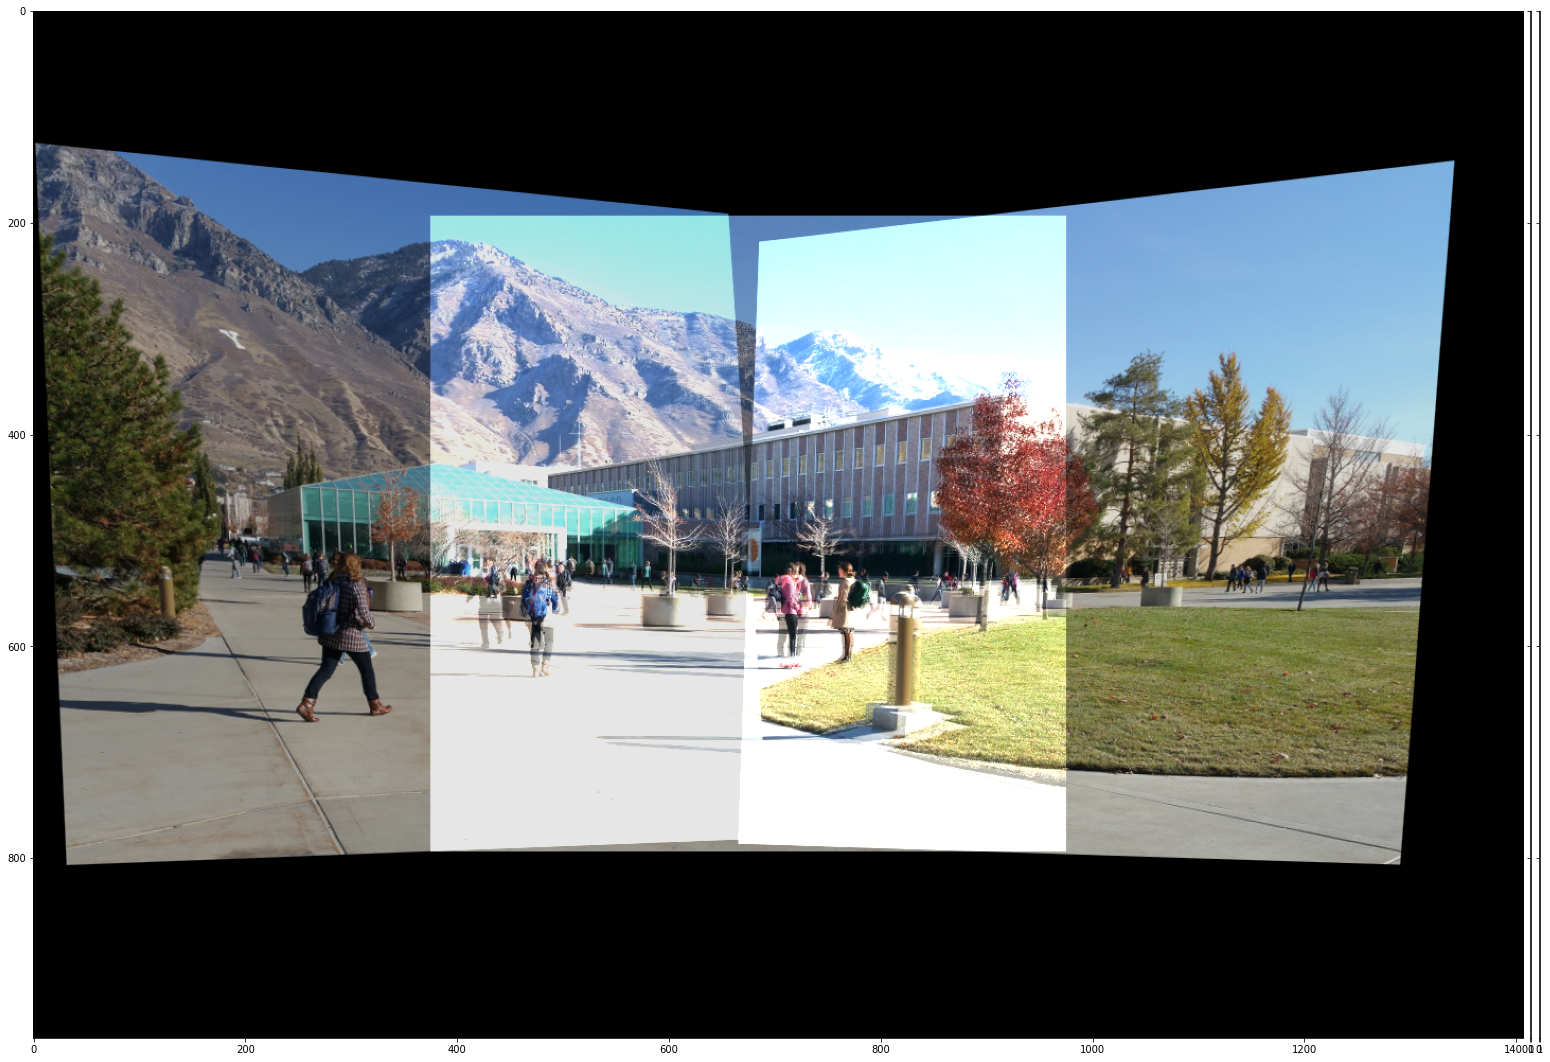

In [47]:
# Place Code Here
# Show an example output here
topleft_left = np.matmul(np.array([0,0,1]), final_homography_lc)
topright_left = np.matmul(np.array([0,600,1]), final_homography_lc)
botright_left = np.matmul(np.array([600,600,1]), final_homography_lc)
botleft_left = np.matmul(np.array([600,0,1]), final_homography_lc)

topleft_mid = topright_left / 2
topright_mid = topleft_mid
topright_mid[0] += 600
botleft_mid = botright_left / 2
botright_mid = botleft_mid
botright_mid[0] += 600
topleft_right = np.matmul(topright_mid / 2, final_homography_cr)
temp1 = topleft_right
temp1[0] += 600
topright_right = np.matmul(temp1, final_homography_cr)
botleft_right = np.matmul(botright_mid / 2, final_homography_cr)
temp2 = botleft_right
temp2 += 600
botright_right = np.matmul(temp2, final_homography_cr)

collection_of_points = np.array([topleft_left, topright_left, botright_left, botleft_left, topleft_mid, topright_mid, botleft_mid, botright_mid, topleft_right, topright_right, botleft_right, botright_right])
#print(collection_of_points)

x_min = np.min(collection_of_points[:, 0])
x_max = np.max(collection_of_points[:, 0])

y_min = np.min(collection_of_points[:, 1])
y_max = np.max(collection_of_points[:, 1])


width = int(x_max)
height = int(y_max)
print(width, height)
final_canvas = np.zeros((height, width, 3))
third = width//3
final_canvas[height//5:height//5+600, int(width/3.75):int(width/3.75)+600] += image_center
cv2.imwrite('final_canvas.jpg', final_canvas)
im = cv2.imread('final_canvas.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#plt.imshow(im, alpha=0.9)

print("x's: ", (width/3.75))
print("y's: ", (height//5))

im2 = merge_images((width/3.75),  (height//5), image_left, final_homography_lc, width, height)
cv2.imwrite('left_side.jpg', im2)
im2 = im2[:, :, ::-1]
#print(final_canvas.shape)
im3 = merge_images((width/3.75),  (height//5), image_right, np.linalg.inv(final_homography_cr), width, height)
cv2.imwrite('right_side.jpg', im3)
im3 = im3[:, :, ::-1]
#im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#final_canvas = overlay_transparent(final_canvas.copy(), image_center, 0, 0)
#plt.imshow(im2, alpha=0.8)
#plt.imshow(im3, alpha=0.7)
#im = overlay_transparent(im, im2, 20, 18)
#im = overlay_transparent(im, im3, 795, 4)
im_end = cv2.addWeighted(im.copy(), 0.9, im2, 0.9, 0)
im_end = cv2.addWeighted(im_end, 0.9, im3, 0.9, 0)
fig = plt.figure(figsize=(27., 27.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [im_end]):
    ax.imshow(im)
plt.show()

In [48]:
im_end = cv2.cvtColor(im_end, cv2.COLOR_RGB2BGR)
cv2.imwrite('final_mosiac.jpg', im_end)

True

### Final Results and Improvements

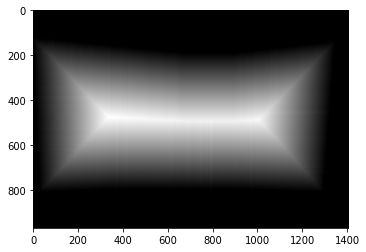

In [49]:
# Output results for additional images here
# Feel free to add as many cells as you wish
from PIL import Image
im_dt = cv2.imread('final_mosiac.jpg')
im_dt = cv2.cvtColor(im_dt, cv2.COLOR_BGR2GRAY)
im_dt = cv2.blur(im_dt, (3,3))
#im_dt = im_dt[200:790, 50:1350]
#_, bw = cv2.threshold(im, -40999, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#bw = np.clip(bw, 0, 255)
#_, bw = cv2.threshold(im, 40, 255, cv2.THRESH_BINARY)
dist = cv2.distanceTransform(im_dt, cv2.DIST_L2, 3)
dist = cv2.blur(dist, (3, 3))
cv2.imwrite('distance_transform.jpg', dist)
#_, dist = cv2.threshold(dist, 0.4, 1.0, cv2.THRESH_BINARY)
#plt.imshow(im, 'gray')

plt.imshow(dist, 'gray')
#im = cv2.imread('final_mosiac.jpg')
#im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#the_final_final = cv2.watershed(im, dist)
#the_final_final = Image.composite()
#plt.imshow(the_final_final)

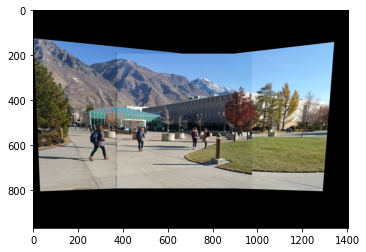

In [50]:
src = cv2.imread('final_canvas.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
src2 = cv2.imread('left_side.jpg')
src2 = cv2.cvtColor(src2, cv2.COLOR_BGR2RGB)
src3 = cv2.imread('right_side.jpg')
src3 = cv2.cvtColor(src3, cv2.COLOR_BGR2RGB)
plt.imshow(src2)
mask = cv2.imread('distance_transform.jpg')
#mask = mask / 255
#the_final_final = src + src2
alpha = 0.1
beta = 0.99
gamma = 0.09
for row in range(len(src)):
    for col in range(len(src[row])):
        if (src[row,col,0] == 0 or src[row,col,1] == 0 or src[row,col,2] == 0) and col <= width//2 - 4:
            src[row,col] = src2[row,col]
        if (src[row,col,0] == 0 or src[row,col,1] == 0 or src[row,col,2] == 0) and col >= width//2 + 4:
            src[row,col] = src3[row,col]
plt.imshow(src)
#src = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
#cv2.imwrite('everything_done.jpg', dst)

#xx = cv2.imread('everything_done.jpg')
#xx = cv2.cvtColor(xx, cv2.COLOR_BGR2GRAY)
#xx = cv2.blur(xx, (7,7))
#dist = cv2.distanceTransform(xx, cv2.DIST_L2, 3)
#dist = cv2.blur(dist, (333, 333))

#dist = 255 - dist
#plt.imshow(dist, 'gray')


### Grading

To get 100% you need to (i) implement RANSAC and additionally (ii) either implement the feature matching yourself (instead of using built-in matching functions such as `cv2.BFMatcher()`), or incorporate one of the following improvements:
* A nice clean compositing/blending approach so that edges/artifacts are not noticeable.
* Automatic selection of which image should be the base
* Handling more than 3 photos
* Another enhancement approved by Dr. Farrell

Points for this assigment will be assigned as follows (100 points total):
* [10 pts] Extracting features from both images (interest points and descriptors).
* [20 pts] Four-point algorithm to estimate homographies.
* [30 pts] RANSAC implemented (partial points given for poor alignments).
* [20 pts] Images warped appropriately (aligning on top of each other).
* [10 pts] Clean final image (extents of merged image should fit the enscribed rectangle).
* [10 pts] Implementing matching or other improvement (see above). Bonus points may be given for additional enhancements.

## Write-up:
Provide an explanation for the following items:
* In what scenarios was it difficult to get good alignments between images?
* If you have any suggestions for how to improve this project in the future, list them here.

- In what scenarios it was hard: The hardest place to get alignments was going from left->right and vise versa. I would say that this was most difficult because there was most likely more than a 60 degree change in camera angle between those pictures. This means that RANSAC and SIFT will not work as well due to the large angle difference in the photos. 
- I think it would be cool if we covered more ways to improve the mocaicing. I spent around 6 hours just figuring out how to improve my image. I probably tried 6 different methods, which I feel I could have been more successful with had we gone over improvements more. 